In [1]:
import os
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split, KFold
sys.path.insert(0, 'C:\\Users\\Utente\\Desktop\\Dev\\Progetti\\OrderAi\\Models\\components\\')
import AdaMB
import Layer

#housing = fetch_california_housing()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 5
epochs = 800
lr = 0.01
batch_size = 300

#X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=3000, n_features=2, noise=10, random_state=5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)

def make_dataset(X_data,y_data,k):
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))
    
dataset = make_dataset(XR, yR, k)

c:\Users\Utente\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(80, 2) * (2, 80) + (1,) = (80, 80)
(80, 2) * (2, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
(80, 80) * (80, 80) + (1,) = (80, 80)
Train_MeanSquaredError:  47.74204
Train_Keras Accuracy:  0.028119901
Train_Keras Precision:  1.0
--------------------------------------------------------
Train_MeanSquaredError:  26.798635
Train_Keras Accuracy:  0.008152611
Train_Keras Precision:  1.0


ValueError: Argument Z must be 2-dimensional.

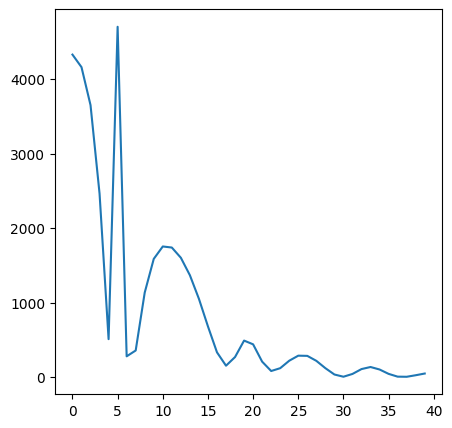

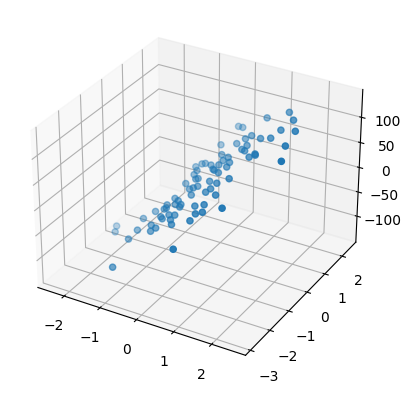

In [37]:
class MLPLinearRegressor(tf.Module):
    def __init__(self, layers, epochs=100, lr=0.01):
        self.layers = layers
        self.epochs = epochs
        self.learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=1000000, decay_rate=0.96, staircase=True)
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.train_mse = tf.keras.metrics.MeanSquaredError()
        self.train_mae = tf.keras.metrics.MeanAbsoluteError()
        self.train_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.test_mse = tf.keras.metrics.MeanSquaredError()
        self.test_mae = tf.keras.metrics.MeanAbsoluteError()
        self.test_accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.regularizer = tf.keras.layers.ActivityRegularization()
        self.loss_history = [e for e in range(epochs)]
        self.bias_history = [e for e in range(epochs)]
        self.mae_train_error_history = [e for e in range(epochs)]
        self.mse_train_error_history = [e for e in range(epochs)]
        self.mae_test_error_history = [e for e in range(epochs)]
        self.mse_test_error_history = [e for e in range(epochs)]
        self.loaded = False

    def calc_history(self, y, y_test, e, loss):
        self.train_mae.update_state(y, self.predicted)
        self.train_mse.update_state(y, self.predicted)
        self.test_mae.update_state(y_test, self.predicted_test)
        self.test_mse.update_state(y_test, self.predicted_test)
        self.bias_history[e] = self.bias
        self.loss_history[e] = loss.numpy()
        self.mae_train_error_history[e] = self.train_mae.result().numpy()
        self.mse_train_error_history[e] = self.train_mse.result().numpy()
        self.mae_test_error_history[e] = self.test_mae.result().numpy()
        self.mse_test_error_history[e] = self.test_mse.result().numpy()
    
    @tf.function
    def lasso(self):
        lassos = [w for w in range(len(self.layers))]
        for w in range(len(self.layers)):
            lassos[w] = tf.reduce_sum(tf.norm(self.layers[w].weights))
        return tf.reduce_mean(lassos)

    @tf.function
    def ridge(self):
        ridges = [w for w in range(len(self.layers))]
        for w in range(len(self.layers)):
            ridges[w] = tf.reduce_sum(tf.square(tf.norm(self.layers[w].weights)))
        return tf.reduce_mean(ridges)

    @tf.function(reduce_retracing=True)
    def train_accuracy_rrsse(self, y, predicted):
        return tf.divide(tf.sqrt(
            tf.divide(
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(predicted, y))))),
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(tf.reduce_mean(y), predicted)))))
            )), predicted.shape[0]
        )

    @tf.function(reduce_retracing=True)
    def loss(self, y, predicted):
        return tf.add(tf.losses.MSE(y, predicted), self.lasso())

    @tf.function(reduce_retracing=True)
    def reset_history_metrics(self):
        self.train_mse.reset_state()
        self.train_mae.reset_state()
        self.test_mse.reset_state()
        self.test_mae.reset_state()

    @tf.function(reduce_retracing=True)
    def calc_metrics(self, y, y_test, predicted_train, predicted_test):
        self.train_mse.reset_state()
        self.train_mae.reset_state()
        self.test_mse.reset_state()
        self.test_mae.reset_state()
        self.train_accuracy.reset_state()
        self.test_accuracy.reset_state()
        self.train_accuracy.update_state(y, predicted_train)
        self.train_mse.update_state(y, predicted_train)
        self.train_mae.update_state(y, predicted_train)
        self.test_accuracy.update_state(y_test, predicted_test)
        self.test_mse.update_state(y_test, predicted_test)
        self.test_mae.update_state(y_test, predicted_test)

    @tf.function(reduce_retracing=True)
    def _forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
        
    @tf.function(reduce_retracing=True)
    def _predict_train(self, X, weights):
        compressed_weights = tf.reduce_mean(tf.subtract(tf.multiply(X, weights), self.bias), axis=1)
        return tf.reduce_mean(tf.add(tf.multiply(tf.transpose(X), compressed_weights), self.bias), axis=1, name="Predict_Train")

    @tf.function
    def _predict_test(self, X_test, compressed_weights):
        return tf.reduce_mean(tf.add(tf.multiply(X_test, compressed_weights), self.bias), axis=1, name="Predict_Test")
    
    def predict(self, x):
        return tf.reduce_mean(tf.add(tf.multiply(x, self.compressed_weights), self.bias))

    @tf.function(reduce_retracing=True)
    def _backprop(self, X, XN, X_test, y, y_test):
        weights = self._forward(XN)
        self.bias = self.layers[len(self.layers)-1].bias

        compressed_weights = tf.reduce_mean(tf.add(tf.multiply(tf.transpose(XN), tf.reduce_mean(weights, axis=0)), self.bias), axis=1)
        flatten_weights = tf.reduce_mean(weights, axis=0)

        predicted_train = self._predict_train(tf.transpose(X), flatten_weights)
        predicted_test = self._predict_test(X_test, compressed_weights)

        loss = tf.nn.scale_regularization_loss(self.loss(y, predicted_train)) 

        return loss, compressed_weights, predicted_train, predicted_test

    def run(self, X, X_test, XN, XN_test, y, y_test):
        self._backprop(X, XN, X_test, y, y_test)
        self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[2].weights,self.layers[3].weights,self.layers[4].weights, self.layers[0].bias, self.layers[1].bias, self.layers[2].bias,self.layers[3].bias,self.layers[4].bias]

        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                loss, self.compressed_weights, self.predicted, self.predicted_test = self._backprop(X, XN, X_test, y, y_test)
                
                self.calc_history(y, y_test, e, loss)

            grads = tape.gradient(loss, self.vars)  
            self.optimizer.apply_gradients(zip(grads, self.vars), ) 
        self.calc_metrics(y, y_test, self.predicted, self.predicted_test)

model = MLPLinearRegressor([
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.nn.relu),
    Layer(activation=tf.sigmoid),
    Layer()
], epochs=epochs, lr=lr, batch_size=batch_size)


def run_model(data, model, X, XN, X_t, XN_t, y, y_t):
    for data in dataset.as_numpy_iterator():
        X_train, XN_train, y_train, X_test, XN_test, y_test = data
        model.reset_history_metrics()
        model.run(X_train, X_test, XN_train, XN_test, tf.squeeze(y_train), tf.squeeze(y_test))
    return X_train, X_test, XN_train, XN_test, tf.squeeze(y_train), tf.squeeze(y_test)
    #model.reset_history_metrics()
    #model.run(X, X_t, XN, XN_t, tf.squeeze(y), tf.squeeze(y_t))


X_train, X_test, XN_train, XN_test, y_train, y_test = run_model(dataset, model, X_train2, normalize_dataset(X_train2), X_test2, normalize_dataset(X_test2), y_train2, y_test2)

In [ ]:
print("\nOriginal: ", y_test[0].numpy(), "\nPredicted: ", model.predict(X_test[0]).numpy(), "\nTested:", model.predicted_test[0].numpy(), "\n")
print("Train_MeanSquaredError: ", model.train_mse.result().numpy())
print("Train_MeanAbsoluteError: ", model.train_mae.result().numpy())
print("Train_MeanSquaredLogError: ", model.train_accuracy.result().numpy())
print('--------------------------------------------------------')
print("Test_MeanSquaredError: ", model.test_mse.result().numpy())
print("Train_MeanAbsoluteError: ", model.test_mae.result().numpy())
print("Test_MeanSquaredLogError: ", model.test_accuracy.result().numpy())

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].plot([e for e in range(epochs)], model.loss_history, label="Loss")
ax[0].plot([e for e in range(epochs)], tf.square(model.bias_history).numpy(), label="Bias")
ax[0].set_ylabel('Loss & Bias History')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot([e for e in range(epochs)], model.mae_train_error_history, label="Train MAE")
ax[1].plot([e for e in range(epochs)], model.mae_test_error_history, label="Test MAE")
ax[1].plot([e for e in range(epochs)], model.mse_train_error_history, label="Train MSE")
ax[1].plot([e for e in range(epochs)], model.mse_test_error_history, label="Test MSE")
ax[1].set_ylabel('Metrics History')
ax[1].set_xlabel('Epochs')
ax[1].legend()

ax[2].scatter(X_train[:, -1], y_train[:])
ax[2].plot(X_train[:, -1], model.predicted[:], color='r')
#ax[2].set_ylim([-200, 200])
#ax[2].set_xlim(-3,3)
ax[2].set_xlabel("Train")

ax[3].scatter(X_test[:, -1], y_test[:])
ax[3].plot(X_test[:, -1], model.predicted_test[:], color='r')
#ax[3].set_ylim([-200, 200])
#ax[3].set_xlim(-3,3)
ax[3].set_xlabel("Test")

fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')
ax3d.scatter(X_train[:, 0], X_train[:, 1], y_train[:])
ax3d.plot(X_train[:, 0], X_train[:, 1], model.predicted[:], color='r')


plt.show()
